# Demo: simulate a live cell imaging dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import traceHMM

In [2]:
%reload_ext autoreload
%autoreload 2

### Test traceHMM implementation with simulated data

Here, we generate a simulated live cell imaging data using the `TraceSimulator` class in the `traceHMM` package. The transition probability and the covariance matrices are listed below.

We also want to simulate the missing data observed in typical live cell imaging data. `TraceSimulator` class provides two methods to simulate missing data:

1. Mask completely at random: at each time point, generate a 0-1 random variable. Mask the value if the random variable is 0.

2. Mask by a Markov chain: generate a 0-1 Markov chain to mask the generated data. To compute the transition matrix of this chain given desired observed probability, one also needs to specify $\mathbb P(\text{stay unobserved})$, which fixes one element of the transition matrix and ensures a unique solution exists.

Here, we demonstrate the second approach and generate 400 traces each of length 500.

In [3]:
# transition probability between three states
P = np.array([
    [0.95, 0.05,    0],
    [0.02, 0.96, 0.02],
    [   0, 0.05, 0.95]
])
# measurement errors added to x, y, and z axes
err = np.diag(np.square([0, 0.06, .12])*2)
# variance at each state
dist_params = (
        {"cov":np.diag(np.ones(3)*0.015), "err":err},
        {"cov":np.diag(np.ones(3)*0.055), "err":err},
        {"cov":np.diag(np.ones(3)*0.085), "err":err}
)
# a uniform initial distribution over the 3 states
tse = traceHMM.TraceSimulator(
    P=P,
    mu=np.array([1/3, 1/3, 1/3]),
    dist_params=dist_params,
    dist_type=traceHMM.model.multivariate_normal,
    random_state=100
)
H, X0 = tse.simulate_multiple_traces(500, 400)
X = tse.mask_by_markov_chain(X0, 0.5, a=0.8)

P(stay observed) = 0.8


After generating the data, we want to check whether the model we implemented can estimate the parameters accurately, given that we know the correct variance at each state.

In [4]:
dist_params = (
        {"cov":np.diag(np.ones(3)*0.015)},
        {"cov":np.diag(np.ones(3)*0.055)},
        {"cov":np.diag(np.ones(3)*0.085)}
)
tm = traceHMM.TraceModel(
    X=X, Pm=np.array([
        [-1, -1,  0],
        [-1, -1, -1],
        [ 0, -1, -1]
    ]), 
    dist_params=dist_params, 
    dist_type=traceHMM.model.multivariate_normal, 
    update_dist_params=["err"]
)
tm.fit(1e3)

Converged at iteration 653


The model converges after 653 iterations. The `TraceModel` class uses the mean absolute difference of the transition matrix between two iterations as the convergence criterion. The model also has a `lklhd` attribute that records the log likelihood of the model at each iteration. From the plot below, we see that the log-likelihood is monotonically increasing, coherent with what we would expect from an expectation-maximization process.

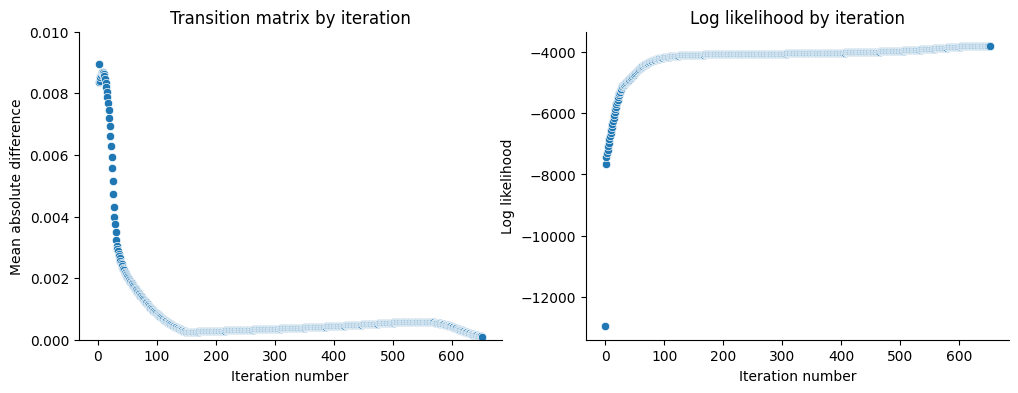

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.scatterplot(tm.convergence, ax=axes[0])
axes[0].set(
    xlabel="Iteration number", ylabel="Mean absolute difference",
    title="Transition matrix by iteration", ylim=(0, 0.01)
)
sns.scatterplot(tm.lklhd, ax=axes[1])
axes[1].set(
    xlabel="Iteration number", ylabel="Log likelihood",
    title="Log likelihood by iteration"
)
plt.show()

The estimated measurement errors are listed below, which are close to `[0, 0.06, 0.12]` as specified in the data generation part.

In [6]:
tm.loc_err

array([0.        , 0.06102365, 0.11988821])

The estimated transition matrix is also close to the true transition matrix, and both give a similar stationary distribution, showing that the chain spends about 22% of time in the looped state in the long run.

Text(0.5, 0.98, 'Estimated transition matrix')

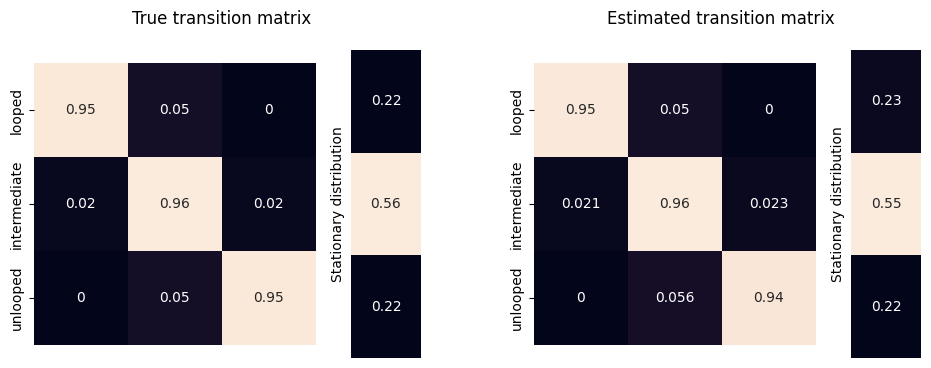

In [7]:
sfigs = plt.figure(figsize=(10, 4)).subfigures(1, 2)
traceHMM.plot.plot_transition_matrix(P, sfigs[0])
sfigs[0].suptitle("True transition matrix")
traceHMM.plot.plot_transition_matrix(tm.P, sfigs[1])
sfigs[1].suptitle("Estimated transition matrix")

Below are some traces along with their predicted/true looping profile.

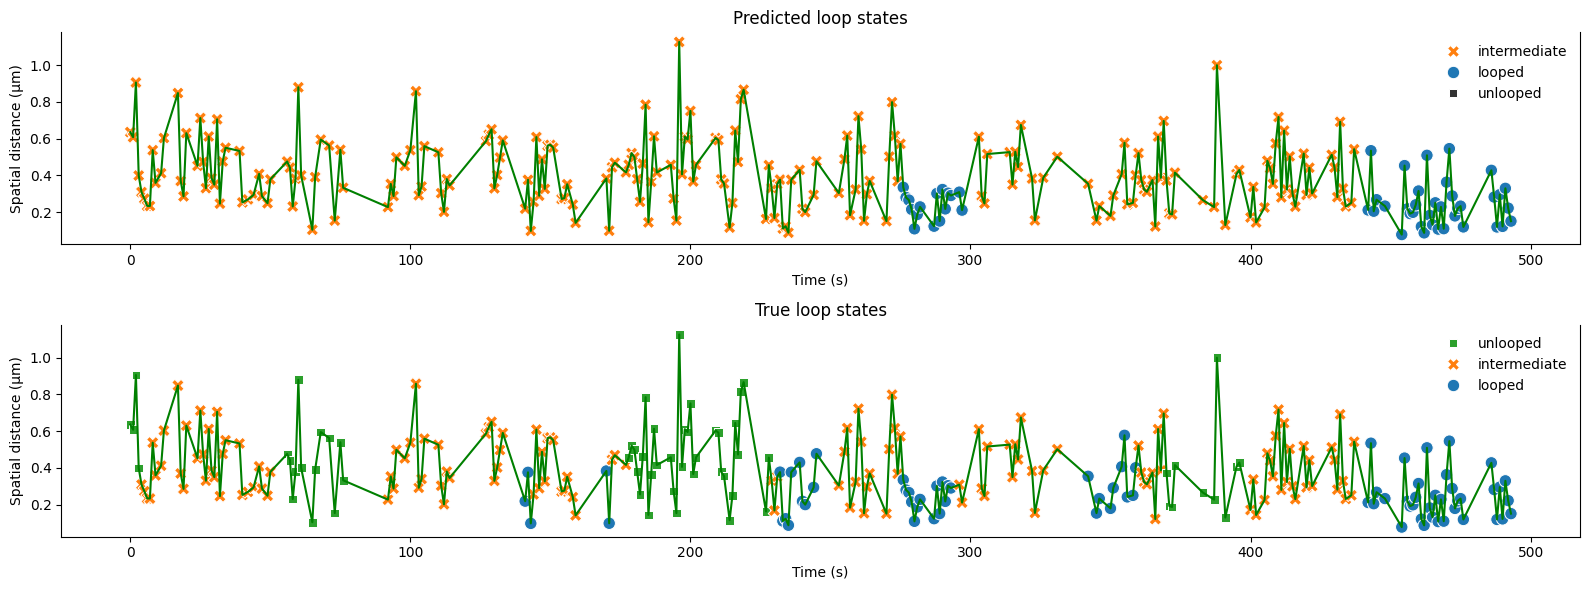

In [8]:
n = 1
dist = np.linalg.norm(X[n], axis=1)
df = pd.DataFrame({"dist":dist, "state":tm.decode(X[[n]])[0]})
df = df.reset_index(names="t")
df["true"] = H[n]
code_book = {0:"looped", 1:"intermediate", 2:"unlooped"}
fig, axes = plt.subplots(2, 1, figsize=(16, 6))
traceHMM.plot.plot_trace(df, "t", "dist", "state", code_book, fig, axes[0])
traceHMM.plot.plot_trace(df, "t", "dist", "true", code_book, fig, axes[1])
axes[0].set(xlabel="Time (s)", ylabel="Spatial distance (µm)", title="Predicted loop states")
axes[1].set(xlabel="Time (s)", ylabel="Spatial distance (µm)", title="True loop states")
fig.tight_layout()

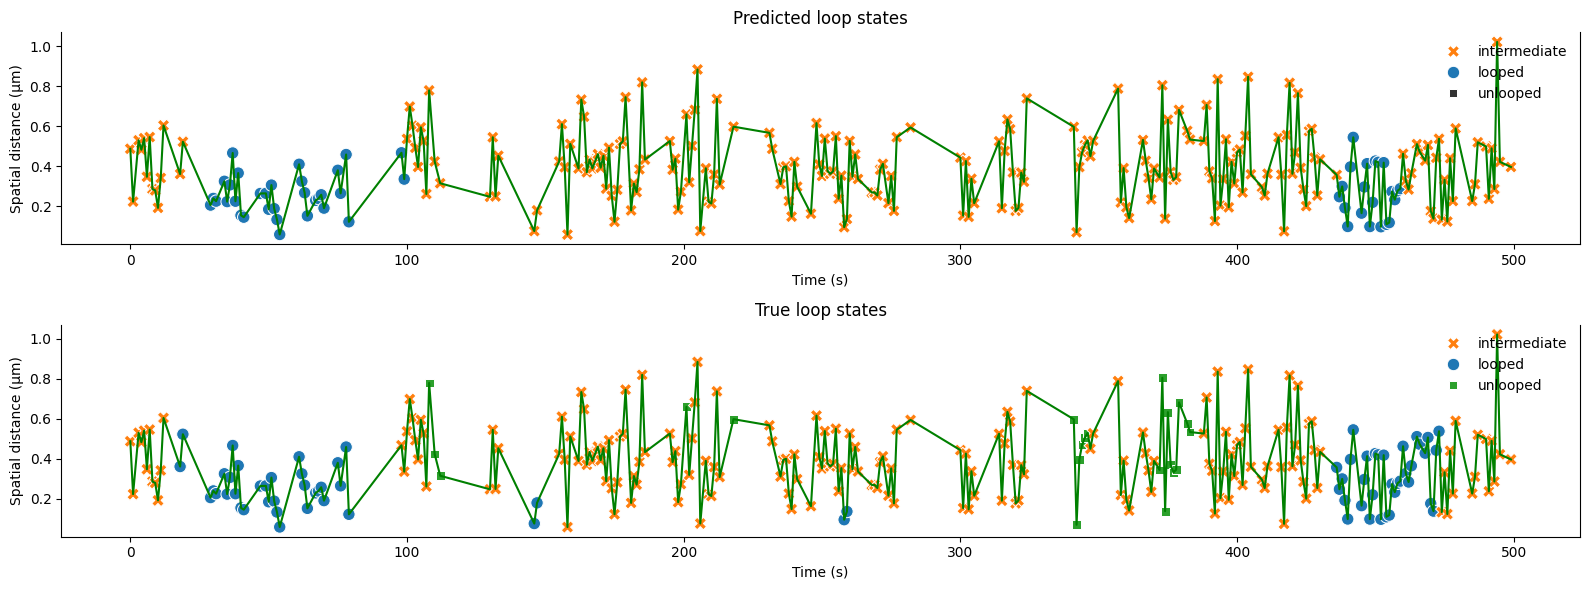

In [9]:
n = 2
dist = np.linalg.norm(X[n], axis=1)
df = pd.DataFrame({"dist":dist, "state":tm.decode(X[[n]])[0]})
df = df.reset_index(names="t")
df["true"] = H[n]
code_book = {0:"looped", 1:"intermediate", 2:"unlooped"}
fig, axes = plt.subplots(2, 1, figsize=(16, 6))
traceHMM.plot.plot_trace(df, "t", "dist", "state", code_book, fig, axes[0])
traceHMM.plot.plot_trace(df, "t", "dist", "true", code_book, fig, axes[1])
axes[0].set(xlabel="Time (s)", ylabel="Spatial distance (µm)", title="Predicted loop states")
axes[1].set(xlabel="Time (s)", ylabel="Spatial distance (µm)", title="True loop states")
fig.tight_layout()

### Ignore the localization error

In this section, we demonstrate why including an additional estimate for measurement error is helpful. Below, we fit a HMM without measurement error assumption:

In [10]:
dist_params = (
        {"cov":np.diag(np.ones(3)*0.015)},
        {"cov":np.diag(np.ones(3)*0.055)},
        {"cov":np.diag(np.ones(3)*0.085)}
)
tm2 = traceHMM.TraceModel(
    X=X, Pm=np.array([
        [-1, -1,  0],
        [-1, -1, -1],
        [ 0, -1, -1]
    ]), 
    dist_params=dist_params, 
    dist_type=traceHMM.model.multivariate_normal, 
)
tm2.fit(int(1e3))

Converged at iteration 214


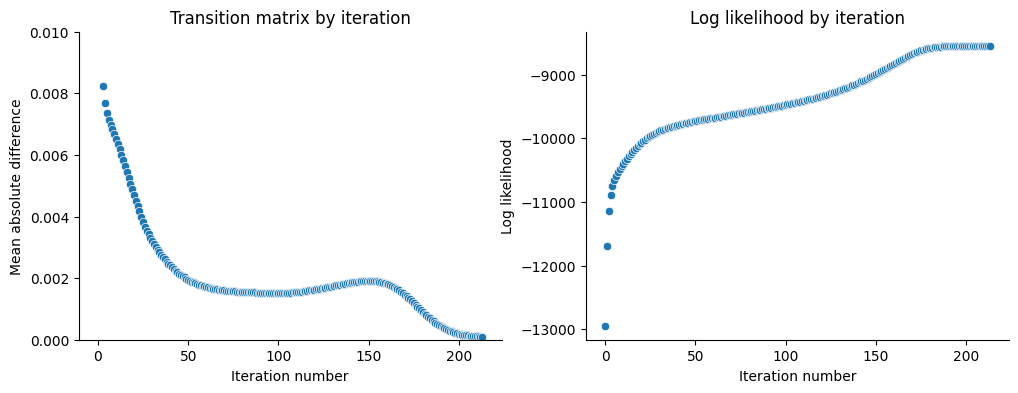

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.scatterplot(tm2.convergence, ax=axes[0])
axes[0].set(
    xlabel="Iteration number", ylabel="Mean absolute difference",
    title="Transition matrix by iteration", ylim=(0, 0.01)
)
sns.scatterplot(tm2.lklhd, ax=axes[1])
axes[1].set(
    xlabel="Iteration number", ylabel="Log likelihood",
    title="Log likelihood by iteration"
)
plt.show()

The estimated transition matrix shows considerable difference from the true one. In addition, with this model, we would say the long run loop fraction is about 12% while the true fraction is twice the estimated one.

Text(0.5, 0.98, 'Estimated transition matrix')

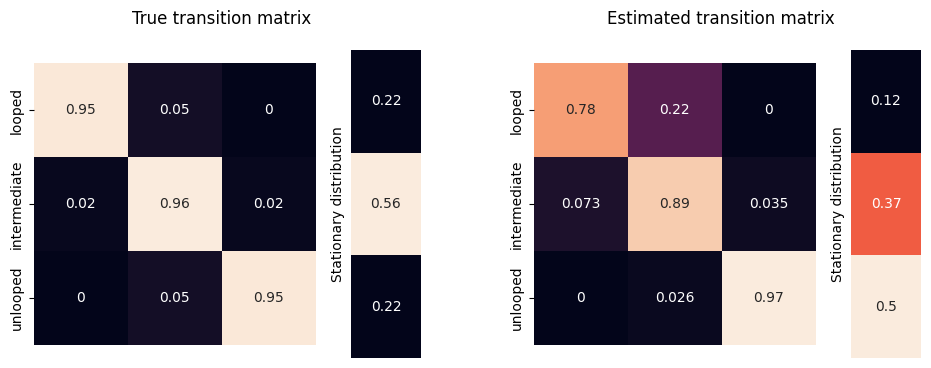

In [12]:
sfigs = plt.figure(figsize=(10, 4)).subfigures(1, 2)
traceHMM.plot.plot_transition_matrix(P, sfigs[0])
sfigs[0].suptitle("True transition matrix")
traceHMM.plot.plot_transition_matrix(tm2.P, sfigs[1])
sfigs[1].suptitle("Estimated transition matrix")

The estimated looping profile is also problematic, as shown below:

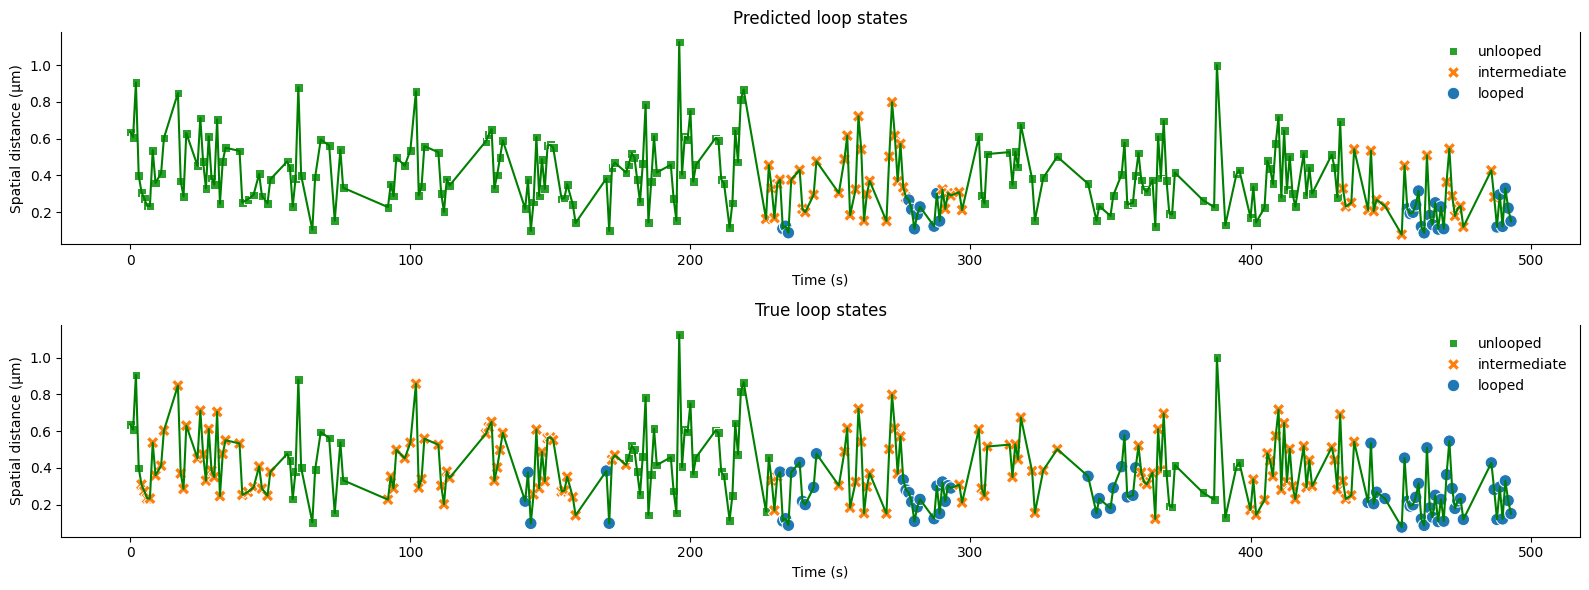

In [13]:
n = 1
dist = np.linalg.norm(X[n], axis=1)
df = pd.DataFrame({"dist":dist, "state":tm2.decode(X[[n]])[0]})
df = df.reset_index(names="t")
df["true"] = H[n]
code_book = {0:"looped", 1:"intermediate", 2:"unlooped"}
fig, axes = plt.subplots(2, 1, figsize=(16, 6))
traceHMM.plot.plot_trace(df, "t", "dist", "state", code_book, fig, axes[0])
traceHMM.plot.plot_trace(df, "t", "dist", "true", code_book, fig, axes[1])
axes[0].set(xlabel="Time (s)", ylabel="Spatial distance (µm)", title="Predicted loop states")
axes[1].set(xlabel="Time (s)", ylabel="Spatial distance (µm)", title="True loop states")
fig.tight_layout()

### Loop Life Time

Since the raw data contains missing values, it is difficult to calculate the loop life time. Given we have already fitted a traceHMM, there are two ways to estimate the average loop life time:

1. Monte Carlo approach: generate some samples according to the fitted transition matrix, and calculate the average loop life time of the sample.

2. First-step analysis of Markov chain: the expected loop life time is the expection of the hitting time from loop state to intermediate state:
    $$
    \mathbb E_0[\tau_1] = p_{11}(\mathbb E_0[\tau_1] + 1) + p_{12}(\mathbb E_1[\tau_1] + 1),
    $$
    where $\mathbb E_i[\tau_j]$ denotes the expectation of the hitting time from the $i$ th state to the $j$ th state. The solution is $1/p_{12}$. That is, the average loop life time is just the inverse of the $12$ th entry of the transition matrix.

In [18]:
tts = traceHMM.TraceSimulator(tm.P, np.ones(3)/3, dist_params, traceHMM.model.multivariate_normal, 0)
Hm, Xm = tts.simulate_single_trace(1000000)

In [19]:
traceHMM.func.avg_loop_life_time(Hm)

19.761629412272374

In [20]:
1/tm.P[0,1]

19.83321708434932

Indeed, they return nearly the same value. The true average loop life time is given below:

In [21]:
traceHMM.func.avg_loop_life_time(H)

19.68839966130398

which is very close to our estimates.